In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import time
import numpy as np 
from tqdm import tqdm 
import os  
import dask.dataframe as dd

from utils import cal_average_bucket_gain, cal_bucket_gain, round_tenth, round_tenth_put, cal_gain_for_all_method
from utils import cal_bucket_hedge_error_all, cal_bucket_gain_all, cal_gain_all_for_all_method 
from utils import cal_method_bucket_gain

## Correlation calculation

In [188]:
df = pd.concat([
    pd.read_hdf('./data_SPX/SPX_Option_C_E.h5'),
    pd.read_hdf('./data_SPX/SPX_Option_P_E.h5')])
df = df[df['volume']>0]
df[['log_return', 'vix']].corr() 

,log_return,vix
log_return,1.000000,-0.237577
vix,-0.237577,1.000000


In [197]:
df[['moneyness', 'delta']].corr()   

,moneyness,delta
moneyness,1.000000,-0.005589
delta,-0.005589,1.000000


In [204]:
k = pd.read_hdf('./data_SPX/SPX_Option_C_E.h5')
k[k['volume']>0][['moneyness', 'delta', 'normalized_T', 'vix', 'log_return']].corr()  

,moneyness,delta,normalized_T,vix,log_return
moneyness,1.000000,0.446627,-0.018625,-0.082642,0.027013
delta,0.446627,1.000000,-0.015705,-0.093974,0.050397
normalized_T,-0.018625,-0.015705,1.000000,0.048981,-0.001737
vix,-0.082642,-0.093974,0.048981,1.000000,-0.212930
log_return,0.027013,0.050397,-0.001737,-0.212930,1.000000


In [205]:
k = pd.read_hdf('./data_SPX/SPX_Option_P_E.h5')
k[k['volume']>0][['moneyness', 'delta',  'normalized_T', 'vix', 'log_return']].corr()   

,moneyness,delta,normalized_T,vix,log_return
moneyness,1.000000,0.650077,0.379857,0.074197,0.014048
delta,0.650077,1.000000,0.005978,-0.108166,0.057373
normalized_T,0.379857,0.005978,1.000000,0.033903,0.010999
vix,0.074197,-0.108166,0.033903,1.000000,-0.253126
log_return,0.014048,0.057373,0.010999,-0.253126,1.000000


In [187]:
df = pd.read_hdf('./data_SPX/vix_return.h5')
df.corr()

,vix,log_return
vix,1.000000,-0.138747
log_return,-0.138747,1.000000


In [190]:
df.columns 

Index(['date', 'cp_flag', 'strike_price', 'volume', 'open_interest',
       'impl_volatility', 'delta', 'gamma', 'vega', 'theta', 'optionid',
       'am_settlement', 'forward_price', 'ticker', 'exercise_style',
       'stock_price', 'moneyness', 'price', 'maturity', 'normalized_T',
       'month', 'dS', 'dV', 'dimp', 'log_return', 'log_return_week',
       'log_return_month', 'vix', 'vix_week', 'vix_month'],
      dtype='object')

### plot hedge strategy

<AxesSubplot:xlabel='BS delta'>

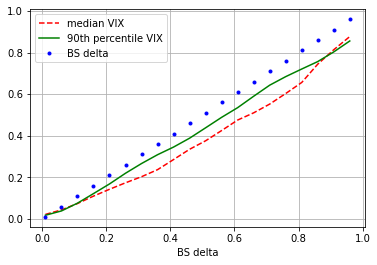

In [172]:
df1 = pd.read_hdf('./data_SPX/SPX_Option_C_E_plot_shuffle_False_trade_True_activation_.h5')
t = df1[df1['normalized_T']==1/12	][['delta', 'vix', 'DNN001']]
t = t.rename(columns={
    'delta': 'BS delta'})
kk = []
for v in t['vix'].unique():
    k = t[t['vix']==v] 
    k = k.rename(columns={"DNN001": str(v)})
    kk.append(k.set_index('BS delta')[str(v)]) 

t = pd.concat(kk, axis=1)  
t['BS delta'] = t.index 
t = t.rename(columns={
    '17.61': 'median VIX', 
    '30.5':'90th percentile VIX'})
t.iloc[::5, 1:].plot(grid=True,style=['r--','g-','b.'])  


Index(['-0.013051548192745042', '0.0005934415594808398',
       '0.012324587594046723'],
      dtype='object')


<AxesSubplot:xlabel='BS delta'>

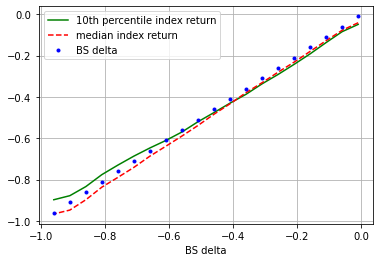

In [173]:
df2 = pd.read_hdf('./data_SPX/SPX_Option_P_E_plot_shuffle_False_trade_True_activation_.h5')

t = df2[df2['normalized_T']==1/12	][['delta', 'log_return', 'DNN01']]
t = t.rename(columns={
    'delta': 'BS delta'})
kk = []
for v in t['log_return'].unique():
    k = t[t['log_return']==v] 
    k = k.rename(columns={"DNN01": str(v)})
    kk.append(k.set_index('BS delta')[str(v)]) 

t = pd.concat(kk, axis=1)  
print(t.columns )
t['BS delta'] = t.index 
t = t.rename(columns={
    '0.0005934415594808398': 'median index return', 
    '-0.013051548192745042':'10th percentile index return'})
t.iloc[::5,[0,1,3]].plot(grid=True, style=['g-','r--','b.'])  

## compute average number of daily samples

In [10]:
df1 = pd.read_hdf('./data_SPX/SPX_Option_C_E.h5')
df2 = pd.read_hdf('./data_SPX/SPX_Option_P_E.h5')

In [11]:
def average_num(df):
    df['year'] = df['date'].apply(lambda x: x.year)
    df = df[ df['volume'] > 0]
    return df.groupby(['year', 'date'])['dS'].count().unstack().mean(axis=1)

In [12]:
average_num(df1) + average_num(df2) 

year
2010     273.365079
2011     301.162698
2012     342.180000
2013     455.972222
2014     620.535714
2015     903.908730
2016    1083.765873
2017    1451.051793
2018    1980.262948
2019    2019.219124
dtype: float64

## generating plot matrix

In [118]:
t = pd.read_hdf('./data_SPX/vix_return.h5')  # since 2000.1.1
tq = t.quantile([0.1, 0.5, 0.9])
tq 

,vix,log_return
0.1,11.941,-0.013052
0.5,17.610,0.000593
0.9,30.500,0.012325


In [119]:
tau = [1/12, 1/2, 1] 
log_return = tq['log_return'].tolist()
vix = tq['vix'].tolist()
delta_list = list(np.linspace(0.01, 0.99, 99))


In [122]:
# for call 
dft = []
for i in range(len(vix)):
    for j in range(len(tau)):
        df = pd.DataFrame(delta_list, columns=['delta']) 
    
        df['normalized_T'] = tau[j]
        df['log_return'] = 0
        df['vix'] = vix[i]

        dft.append(df)

dft = pd.concat(dft).reset_index(drop=True)
dft['dV'] = 0
dft['dS'] = 0
dft#.to_hdf('./data_SPX/SPX_Option_C_E_plot.h5',key='callplot') 

,delta,normalized_T,log_return,vix,dV,dS
0,0.01,0.083333,0,11.941,0,0
1,0.02,0.083333,0,11.941,0,0
2,0.03,0.083333,0,11.941,0,0
3,0.04,0.083333,0,11.941,0,0
4,0.05,0.083333,0,11.941,0,0
...,...,...,...,...,...,...
886,0.95,1.000000,0,30.500,0,0
887,0.96,1.000000,0,30.500,0,0
888,0.97,1.000000,0,30.500,0,0
889,0.98,1.000000,0,30.500,0,0


In [139]:
# for put
dft = []
for i in range(len(log_return)):
    for j in range(len(tau)):
        df = - pd.DataFrame(delta_list, columns=['delta']) 
    
        df['normalized_T'] = tau[j]
        df['log_return'] = log_return[i]
        df['vix'] = 0

        dft.append(df)

dft = pd.concat(dft).reset_index(drop=True)      
dft['dV'] = 0
dft['dS'] = 0
dft#.to_hdf('./data_SPX/SPX_Option_P_E_plot.h5',key='putplot') 

,delta,normalized_T,log_return,vix,dV,dS
0,-0.01,0.083333,-0.013052,0,0,0
1,-0.02,0.083333,-0.013052,0,0,0
2,-0.03,0.083333,-0.013052,0,0,0
3,-0.04,0.083333,-0.013052,0,0,0
4,-0.05,0.083333,-0.013052,0,0,0
...,...,...,...,...,...,...
886,-0.95,1.000000,0.012325,0,0,0
887,-0.96,1.000000,0.012325,0,0,0
888,-0.97,1.000000,0.012325,0,0,0
889,-0.98,1.000000,0.012325,0,0,0


## calculate gain for stocks

In [159]:
def cal_hedge_error(df, gain=False):
    error_dict = {}
    gain_dict = {}
    method_list = ['delta']
    for col in list(df.columns):
        if ('MV' in col or 'DNN' in col or 'RNN' in col) and ('error' not in col):
            method_list.append(col)

    for meth in method_list:
        df[meth+'_sq_error'] = (df['dV'] - df[meth]* df['dS']) **2
        error_dict[meth] = df.groupby('ticker') [meth+'_sq_error'].mean()
        error_dict[meth]['Total'] = np.mean(df[meth+'_sq_error'] )
        if gain and meth!= 'delta' :
            gain_dict[meth] = 1 -   error_dict[meth] / error_dict['delta']
    if gain:
        return pd.concat(gain_dict, axis=1)
    return pd.concat(error_dict, axis=1)

### semiconduct

In [175]:
name = 'All_Option_C_A_trade_True_transfer_False_hidden_size_128.h5' 
df = pd.read_hdf('./data_semiconduct/'+name) 
cal_hedge_error(df, gain=True)#.round(4).to_csv('semiconduct_C_all_methhod_gain.csv')

,MVdelta_ind,DNN0_ind,DNN01_ind,DNN001_ind,MVdelta_all,DNN0,DNN01,DNN001
ticker,,,,,,,,
ADI,-0.036139,-0.027193,-0.008705,0.005231,-0.009910,-0.017694,-0.006517,-0.011575
AMAT,-0.133708,-0.107146,-0.048810,-0.076983,-0.022720,-0.118754,-0.057652,-0.107135
AMD,-0.125298,-0.088845,-0.130374,-0.043038,-0.007558,-0.073592,-0.036321,-0.054829
AVGO,-0.011066,0.000900,-0.018311,0.022431,-0.266279,0.032789,0.050361,0.071825
INTC,-0.040428,-0.029709,-0.007709,-0.029044,-0.002892,-0.048238,-0.034403,-0.036501
KLAC,-0.565436,-0.187218,-0.171577,-0.598563,-0.095276,-0.061270,-0.023528,-0.026016
LRCX,-0.464365,-0.267194,-0.181334,-0.258478,-0.510827,-0.258068,-0.096716,-0.241676
MCHP,-0.157058,-0.084887,-0.018882,-0.039517,-0.013415,-0.033145,-0.001857,0.007097
MPWR,0.050971,0.069751,0.054971,0.042385,0.104112,0.090798,0.071119,0.053294


In [177]:
name = 'All_Option_P_A_trade_True_transfer_False_hidden_size_128.h5' 
df = pd.read_hdf('./data_semiconduct/'+name)  
cal_hedge_error(df, gain=True)#.round(4).to_csv('semiconduct_P_all_methhod_gain.csv')

,MVdelta_ind,DNN0_ind,DNN01_ind,DNN001_ind,MVdelta_all,DNN0,DNN01,DNN001
ticker,,,,,,,,
ADI,0.000369,-0.002221,-0.007496,-0.024926,-0.007398,-0.010378,-0.019553,-0.017443
AMAT,-0.057232,-0.043723,-0.050179,-0.050604,-0.014948,-0.032527,-0.011975,-0.014338
AMD,-0.022121,-0.008030,-0.094944,-0.018751,-0.011212,-0.030252,-0.021444,-0.018867
AVGO,0.012785,-0.045287,-0.033654,-0.003291,-0.006715,0.006718,0.009698,0.052501
INTC,0.003574,0.001868,-0.011101,-0.006258,0.003905,0.002387,0.006133,-0.019511
KLAC,-0.014188,-0.074211,-0.088124,-0.155212,-0.020260,-0.019137,-0.007390,-0.027676
LRCX,-0.121861,-0.064995,-0.016209,-0.054331,-0.168107,-0.049875,-0.003720,-0.035858
MCHP,-0.017803,-0.039604,-0.042211,-0.028899,-0.010108,-0.019574,-0.031014,0.013840
MPWR,-0.030070,-0.019774,-0.036957,-0.029259,-0.029499,-0.039847,-0.045640,-0.026297


### all stocks

In [19]:
num = 64
name = 'All_Option_C_A_trade_True_transfer_False_hidden_size_'+str(num)+'.h5'
df = pd.read_hdf('./data_All/'+name)
cal_hedge_error(df, gain=True)#.round(4).to_csv('all_option_all_methhod_gain'+str(num)+'.csv')

,MVdelta_ind,DNN0_ind,DNN01_ind,DNN001_ind,MVdelta_all,DNN0,DNN01,DNN001
ticker,,,,,,,,
AAPL,0.056857,0.085953,0.021889,0.089038,0.027288,0.060523,0.012798,0.098429
AMD,-0.125298,-0.090543,-0.115422,-0.093002,-0.000423,-0.111100,-0.021508,-0.023796
AMZN,0.065576,0.065135,-0.030950,0.018069,0.025957,0.032951,-0.070488,0.091811
BA,0.006889,-0.001469,0.002631,0.017789,0.029776,-0.022302,0.027357,0.004008
BAC,-0.479636,-0.264237,-0.200023,-0.081424,0.000820,-0.064964,-0.045776,-0.019860
CCL,0.021138,0.001360,-0.024199,-0.010278,0.006745,-0.003103,-0.075694,0.034143
CSCO,-0.087668,-0.030784,-0.024152,0.009488,0.001915,-0.004470,-0.040757,0.017571
DAL,-0.039083,-0.030966,-0.060657,-0.026917,0.001507,-0.016736,-0.061123,0.016936
DIS,-0.241705,-0.188211,-0.067512,-0.100120,-0.008166,-0.163990,0.000452,0.036709


In [17]:
num = 64
name = 'All_Option_P_A_trade_True_transfer_False_hidden_size_'+str(num)+'.h5'
df = pd.read_hdf('./data_All/'+name)
res1 = cal_hedge_error(df, gain=True)#.to_csv('all_option_all_methhod_gain_P'+str(num)+'.csv')

num = 128
name = 'All_Option_P_A_trade_True_transfer_False_hidden_size_'+str(num)+'.h5'
df = pd.read_hdf('./data_All/'+name)
res2 = cal_hedge_error(df, gain=True)#.to_csv('all_option_all_methhod_gain_P'+str(num)+'.csv')

for name in ['DNN0', 'DNN01', 'DNN001']:
    res1[name] = res2[name]

res1#.round(4).to_csv('all_option_all_methhod_gain_P'+str(64)+'.csv')

In [4]:
df = pd.read_hdf('./data_All/All_Option_C_A_trade_True_transfer_True_8.h5')
cal_hedge_error(df, gain=True) 

,MVdelta,MVdelta_all,DNN1,DNN0,DNN01,DNN001,DNN0011,DNN0001,DNN0002
ticker,,,,,,,,,
AAPL,0.056857,0.025910,0.064032,-0.003837,0.027990,0.067222,0.085173,0.050015,-0.019613
AMD,NaN,-0.000398,-0.031600,-0.029015,-0.042067,-0.008999,-0.046768,-0.047500,-0.158788
AMZN,0.065576,0.037054,0.049288,0.028213,0.054524,0.031912,0.129975,0.033238,0.012279
BA,0.006889,0.028669,0.010900,-0.008044,0.011047,-0.067467,-0.027521,-0.002233,-0.048105
BAC,NaN,0.000778,-0.016227,-0.024574,-0.025909,-0.034153,-0.083402,-0.029862,-0.072706
CCL,NaN,0.006396,0.013037,-0.013248,-0.007026,-0.047434,-0.009480,-0.023241,-0.127013
CSCO,NaN,0.001814,0.001365,-0.001281,-0.002401,0.005565,-0.005078,-0.010572,-0.042874
DAL,NaN,0.001431,0.000415,-0.001395,-0.029985,0.005958,0.009921,-0.002518,-0.047035
DIS,NaN,-0.007696,-0.095798,-0.078968,-0.024423,0.036967,0.016613,-0.092263,-0.187445


In [3]:
df = pd.read_hdf('./data_All/All_Option_C_A_trade_True_transfer_True_8.h5')

# count data number 
cnt = df.groupby('ticker')['dS'].count().sort_values(ascending=False)
cnt /= cnt.sum()
pd.concat({
    'percent': cnt,
    'cum_percent': cnt.cumsum(),
    'count': pd.Series(range(len(cnt)), index=cnt.index)
}, axis=1)

,percent,cum_percent,count
ticker,,,
AMZN,0.181498,0.181498,0
AAPL,0.094341,0.275839,1
NFLX,0.087952,0.363791,2
BA,0.083674,0.447465,3
NVDA,0.070702,0.518167,4
AMD,0.060689,0.578856,5
MSFT,0.057453,0.636309,6
DIS,0.051330,0.687639,7
BAC,0.037875,0.725514,8


### RNN model 

In [81]:
def cal_gain_rnn(k2, TYPE='C'):
    if TYPE == 'C':
        k2['delta_bucket'] = k2['delta'].apply(round_tenth)
    else:
        k2['delta_bucket'] = k2['delta'].apply(round_tenth_put)
        
    k2['detladS'] = k2['delta'] * k2['dS']    
    k2['base'] = k2['dV'] - k2['detladS']
    k2['base_sq'] = k2['base']**2
    base_score = k2.groupby('delta_bucket')['base_sq'].mean()
    base_score['total'] = np.mean(k2['base_sq'] )

    scores = {}
    scores['base'] = base_score
    gain = {}

    # RNN
    DNN_set = ['RNN']
    for name in DNN_set:
        k2[name+'_diff'] = k2['dV'] - k2[name]*k2['dS']
        k2[name+'_sq'] = k2[name+'_diff']**2
        tmp_score = k2.groupby('delta_bucket')[name+'_sq'].mean() 
        tmp_score['total'] = np.mean(k2[name+'_sq'] )
        tmp_gain = 1 - tmp_score / base_score 
        scores[name] = tmp_score

        gain[name] = tmp_gain
    
    #print(pd.concat(scores, axis=1))
    gain = pd.concat(gain, axis=1)
    return gain 


In [82]:
df = pd.read_hdf('./data_SPX/SPX_Option_C_E_activation_hidden_size_8_num_layer_1_.h5')
cal_gain_rnn(df).T 

delta_bucket,1,2,3,4,5,6,7,8,9,total
RNN,0.198666,0.245529,0.233319,0.230081,0.25124,0.295394,0.313261,0.29722,0.090724,0.258006


In [83]:
df = pd.read_hdf('./data_SPX/SPX_Option_P_E_activation_hidden_size_8_num_layer_1_.h5')
cal_gain_rnn(df, TYPE='P').T 

delta_bucket,1,2,3,4,5,6,7,8,9,total
RNN,0.128073,0.243895,0.232597,0.199598,0.142876,0.061081,-0.006518,-0.022181,-0.0183,0.160715


In [12]:
# for RNN model
# combine vix and log return together
t = pd.read_csv('./data_SPX/VIX.csv')
t['Date'] = pd.to_datetime(t['Date'].apply(str))
t = t[['Date', 'vix']]

p = pd.read_hdf('./data_SPX/SPX_Price.h5')
p = p[['Close', 'Volume']]
p['log_return'] = p['Close'] / p['Close'].shift(1)
p['log_return'] = p['log_return'].apply(np.log)

t = t.loc[ t['Date'].apply(lambda x: x in p.index)].copy()
t['log_return'] = t['Date'].apply(lambda x: p.loc[x, 'log_return'])

t.set_index('Date').to_hdf('./data_SPX/vix_return.h5', key='vix_return')

## MV delta 
* coefficients forecast

<AxesSubplot:>

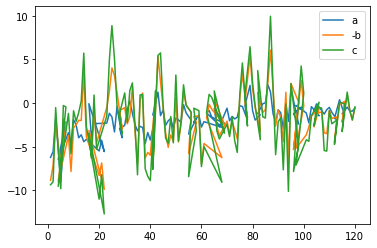

In [32]:
name = 'month'
#name = 'date'
t = pd.read_hdf('./data_SPX/coefs_'+name+'_1.h5')
t['-b'] = -t['b']
t[['a', '-b', 'c']].plot()

In [33]:
t.iloc[:20]

,a,b,c,-b
1,-6.224392,8.855971,-9.366726,-8.855971
2,-5.561879,7.142248,-9.013590,-7.142248
3,-1.679546,2.295469,-0.520492,-2.295469
5,-8.938827,7.181530,-9.818389,-7.181530
6,-5.054282,1.819493,-0.286259,-1.819493
7,-2.173632,2.552225,-0.443313,-2.552225
4,-6.451642,8.939866,-9.551733,-8.939866
8,-3.392705,3.746881,-1.190323,-3.746881
9,-4.682226,7.841907,-5.810364,-7.841907
10,-1.910816,2.839457,-0.885213,-2.839457


<AxesSubplot:>

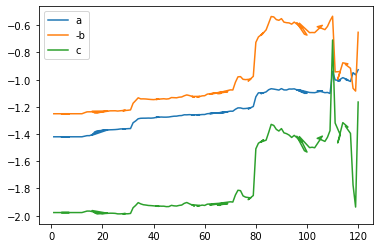

In [34]:
name = 'month'
#name = 'date'
t = pd.read_hdf('./data_SPX/coefs_'+name+'_12.h5')
t['-b'] = -t['b']
t[['a', '-b', 'c']].plot()

<AxesSubplot:>

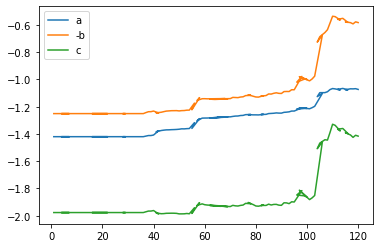

In [35]:
name = 'month'
#name = 'date'
t = pd.read_hdf('./data_SPX/coefs_'+name+'_36.h5')
t['-b'] = -t['b']
t[['a', '-b', 'c']].plot()

## Data Exploration

In [36]:
df = pd.read_hdf('./data_All/All_Option_C_A.h5')

In [37]:
df.shape  

(5937905, 33)

In [38]:
def bucket_count(df, name='delta', trade=True, TYPE='C'):
    if TYPE == 'C':
        df['delta_bucket'] = df['delta'].apply(round_tenth)
    else:
        df['delta_bucket'] = df['delta'].apply(round_tenth_put)

    if trade:
        df = df[df['volume']>0]
    if name == 'delta':
        res = df.groupby(['ticker', 'delta_bucket'])[name].count().unstack()
    elif name == 'volume':
        res = df.groupby(['ticker', 'delta_bucket'])[name].sum().unstack()
    res['total'] = res.sum(axis=1)
    return res 


In [39]:
cnt1 = bucket_count(df)
cnt1 

delta_bucket,1,2,3,4,5,6,7,8,9,total
ticker,,,,,,,,,,
AAPL,87584,65542,56235,52233,53166,53724,53223,55783,63913,541403
AMD,13868,13623,13023,12344,11867,11874,11572,11760,12537,112468
AMZN,64638,56713,53433,54986,64278,70373,53173,44988,39120,501702
BA,25504,22730,21029,21535,23837,23251,20352,19190,17709,195137
BAC,27461,18895,15397,13589,12926,13832,14636,17518,23147,157401
CCL,5128,7271,8059,8140,8170,6554,5136,3820,2590,54868
CSCO,18940,17164,15062,13891,13781,13561,13754,14660,13435,134248
DAL,10316,11943,12323,12729,13531,13114,11372,10105,8172,103605
DIS,19722,16815,14963,14673,15834,16169,16177,16469,14341,145163


In [40]:
cnt2 = bucket_count(df, trade=False)
cnt2 

delta_bucket,1,2,3,4,5,6,7,8,9,total
ticker,,,,,,,,,,
AAPL,116808,77535,64237,57488,55778,56858,63021,77124,113956,682805
AMD,27984,18453,15724,14177,13114,12827,13474,15898,22545,154196
AMZN,110712,88838,84636,84822,92227,103455,113623,136181,205629,1020123
BA,46700,33897,28896,27726,28567,30587,34753,44091,62778,337995
BAC,33794,20188,15793,13775,13047,14199,15919,20792,33803,181310
CCL,21750,16774,15053,14402,14732,15623,17424,20901,26609,163268
CSCO,29954,19844,16036,14593,14524,15396,17500,22697,29678,180222
DAL,26885,19947,17724,16880,17242,18693,20631,26232,36791,201025
DIS,31310,22203,18167,17112,17687,19409,24005,31226,43231,224350


In [41]:
ratio = cnt1 / cnt2 
ratio.loc['average'] = ratio.mean(axis=0)
ratio 

delta_bucket,1,2,3,4,5,6,7,8,9,total
ticker,,,,,,,,,,
AAPL,0.749812,0.845321,0.875430,0.908590,0.953172,0.944880,0.844528,0.723290,0.560857,0.792910
AMD,0.495569,0.738254,0.828224,0.870706,0.904911,0.925704,0.858839,0.739716,0.556088,0.729383
AMZN,0.583839,0.638387,0.631327,0.648252,0.696954,0.680228,0.467977,0.330354,0.190246,0.491805
BA,0.546124,0.670561,0.727748,0.776708,0.834424,0.760160,0.585619,0.435236,0.282089,0.577337
BAC,0.812600,0.935952,0.974926,0.986497,0.990726,0.974153,0.919404,0.842536,0.684762,0.868132
CCL,0.235770,0.433468,0.535375,0.565199,0.554575,0.419510,0.294766,0.182766,0.097335,0.336061
CSCO,0.632303,0.864947,0.939262,0.951895,0.948843,0.880813,0.785943,0.645900,0.452692,0.744904
DAL,0.383708,0.598737,0.695272,0.754088,0.784770,0.701546,0.551209,0.385217,0.222120,0.515384
DIS,0.629895,0.757330,0.823636,0.857468,0.895234,0.833067,0.673901,0.527413,0.331730,0.647038


In [42]:
def bucket_ratio(df, name='delta', TYPE='C'):
    cnt1 = bucket_count(df, name=name, trade=True, TYPE=TYPE)
    cnt2 = bucket_count(df, name=name, trade=False, TYPE=TYPE)

    ratio = cnt1 / cnt2 
    ratio.loc['average'] = ratio.mean(axis=0)
    return ratio 


In [43]:
dfc = pd.read_hdf('./data_SPX/SPX_Option_C_E.h5')
dfp = pd.read_hdf('./data_SPX/SPX_Option_P_E.h5')

In [44]:
df = dfc 
df['month'] = df['date'].apply(lambda x: (x.year-2010)*12+x.month)
df['delta_bucket'] = df['delta'].apply(round_tenth)

k = df[df['volume']>0].groupby(['month', 'delta_bucket'])['delta'].count().unstack()


<AxesSubplot:xlabel='month'>

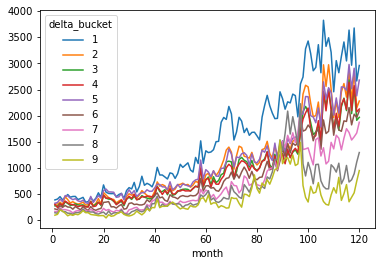

In [45]:
k.plot()

In [46]:
bucket_ratio(dfc) 

delta_bucket,1,2,3,4,5,6,7,8,9,total
ticker,,,,,,,,,,
SPX,0.591386,0.569071,0.533119,0.51496,0.548237,0.343264,0.223575,0.123725,0.048237,0.283971
average,0.591386,0.569071,0.533119,0.51496,0.548237,0.343264,0.223575,0.123725,0.048237,0.283971


In [47]:
bucket_ratio(dfp, TYPE='P')

delta_bucket,1,2,3,4,5,6,7,8,9,total
ticker,,,,,,,,,,
SPX,0.472516,0.536953,0.52918,0.544496,0.531908,0.340889,0.246454,0.158672,0.075729,0.415125
average,0.472516,0.536953,0.52918,0.544496,0.531908,0.340889,0.246454,0.158672,0.075729,0.415125


In [48]:
scnt1 = bucket_count(dfc)
scnt1

delta_bucket,1,2,3,4,5,6,7,8,9,total
ticker,,,,,,,,,,
SPX,184416,131526,113975,113110,133169,98666,82827,66853,48707,973249


In [49]:
scnt11 = bucket_count(dfc, name='volume')

scnt11_ratio  = scnt11 / scnt11.loc['SPX', 'total']
scnt11_ratio

delta_bucket,1,2,3,4,5,6,7,8,9,total
ticker,,,,,,,,,,
SPX,0.179362,0.167909,0.136553,0.127562,0.266374,0.079517,0.02348,0.011729,0.007515,1.0


In [50]:
scnt11 

delta_bucket,1,2,3,4,5,6,7,8,9,total
ticker,,,,,,,,,,
SPX,84724435,79314348,64502714,60255753,125825904,37560840,11090898,5540304,3549921,472365117


In [51]:
scnt2 = bucket_count(dfc, trade=False)
scnt2 

delta_bucket,1,2,3,4,5,6,7,8,9,total
ticker,,,,,,,,,,
SPX,311837,231124,213789,219648,242904,287435,370466,540335,1009749,3427287


In [52]:
scntp1 = bucket_count(dfp, TYPE='P')
scntp1

delta_bucket,1,2,3,4,5,6,7,8,9,total
ticker,,,,,,,,,,
SPX,455078,280321,191206,153911,127711,74338,52508,37157,25105,1397335


In [53]:
scntp11 = bucket_count(dfp, name='volume', TYPE='P')

scntp11_ratio  = scntp11 / scntp11.loc['SPX', 'total']
scntp11_ratio

delta_bucket,1,2,3,4,5,6,7,8,9,total
ticker,,,,,,,,,,
SPX,0.285349,0.212793,0.145035,0.13597,0.173001,0.029933,0.010212,0.005223,0.002483,1.0


In [54]:
pd.concat([scntp11_ratio, scnt11_ratio], axis=0)#.to_csv('spx_trade.csv')

delta_bucket,1,2,3,4,5,6,7,8,9,total
ticker,,,,,,,,,,
SPX,0.285349,0.212793,0.145035,0.135970,0.173001,0.029933,0.010212,0.005223,0.002483,1.0
SPX,0.179362,0.167909,0.136553,0.127562,0.266374,0.079517,0.023480,0.011729,0.007515,1.0


In [55]:
scntp11 

delta_bucket,1,2,3,4,5,6,7,8,9,total
ticker,,,,,,,,,,
SPX,198927906,148346495,101109517,94790167,120605941,20867230,7119384,3641334,1730963,697138937


In [56]:
scntp2 = bucket_count(dfp, trade=False, TYPE='P')
scntp2 

delta_bucket,1,2,3,4,5,6,7,8,9,total
ticker,,,,,,,,,,
SPX,963095,522059,361325,282667,240100,218071,213054,234175,331511,3366057


In [57]:
from scipy.stats import norm

In [58]:
def cal_delta(S, K, r, t, T, sigma):
    tau = T - t
    F = np.exp(r*tau) *  S 
    d = np.log(F/K) + 0.5 * sigma**2 * tau 
    d /= (sigma * np.sqrt(tau))

    delta = norm.cdf(d)
    print(tau, F, d, delta)
    return delta


In [59]:
S = 100
K = 100
r = 0.02
t = 0.05
T = 1
sigma = 0.2 

In [60]:
cal_delta(S, K, r, t, T, sigma)

0.95 101.9181648617408 0.19493588689617986 0.5772784303018487


0.5772784303018487

In [61]:
dsigma = 0.05 
cal_delta(S, K, r, t, T, sigma+dsigma)

0.95 101.9181648617408 0.1998092840685842 0.5791851299456096


0.5791851299456096

In [ ]:
class MyTimer(object):
    '''
    用上下文管理器计时
    '''
    def __init__(self, name=''):
        self.name = name

    def __enter__(self):
        self.t0 = time.time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        print('['+self.name+' : finished, spent time: {time:.2f}s]'.format(time = time.time() - self.t0))


In [ ]:
with MyTimer() as t:
    k3 = pd.read_hdf('./data2_SPX/SPX_Option_C_E.h5') 

[finished, spent time: 0.61s]


In [ ]:
with MyTimer('dask dataframe') as t:
    df = dd.read_csv('./data2_SPX/SPX_Option.csv')
with MyTimer('pandas') as t:
    df = pd.read_csv('./data2_SPX/SPX_Option.csv', low_memory=False)

[dask dataframe : finished, spent time: 0.02s]
[pandas : finished, spent time: 30.89s]


In [67]:
def cal_gain(k2, TYPE='C'):
    if TYPE == 'C':
        k2['delta_bucket'] = k2['delta'].apply(round_tenth)
    else:
        k2['delta_bucket'] = k2['delta'].apply(round_tenth_put)
        
    k2['detladS'] = k2['delta'] * k2['dS']
    for name in ['MVdelta']: #['dimp', 'MVdelta', 'MVDNN']:
        k2[name+'vega'] = k2[name] / k2['stock_price'] * 1000 * k2['vega'] # scale 
    
    k2['base'] = k2['dV'] - k2['detladS']
    k2['base_sq'] = k2['base']**2
    base = k2['base']
    base_score = k2.groupby('delta_bucket')['base_sq'].mean()
    base_score['total'] = np.mean(k2['base_sq'] )

    scores = {}
    scores['base'] = base_score
    gain = {}
    for name in ['MVdelta']: #['dimp', 'MVdelta', 'MVDNN']: 
        k2['tmp'] = base - k2[name+'vega']
        k2['tmp_sq'] = k2['tmp']**2
        tmp_total = np.mean(k2['tmp_sq'])

        tmp_score = k2.groupby('delta_bucket')['tmp_sq'].mean()
        tmp_score['total'] = np.mean(k2['tmp_sq'] )
        tmp_gain = 1 - tmp_score / base_score 
        scores[name] = tmp_score
        gain[name] = tmp_gain

    # DNN
    #DNN_set = ['MVdelta']
    DNN_set = []
    for name in k2.columns:
        if 'DNN' in name and 'MV' not in name:
            DNN_set.append(name)
    for name in DNN_set:
        k2[name+'_diff'] = k2['dV'] - k2[name]*k2['dS']
        k2[name+'_sq'] = k2[name+'_diff']**2
        tmp_score = k2.groupby('delta_bucket')[name+'_sq'].mean() 
        tmp_score['total'] = np.mean(k2[name+'_sq'] )
        tmp_gain = 1 - tmp_score / base_score 
        scores[name] = tmp_score

        gain[name] = tmp_gain
    
    #print(pd.concat(scores, axis=1))
    gain = pd.concat(gain, axis=1)
    gain.to_csv('gain_activation_'+TYPE+'.csv')
    return gain 


In [ ]:
#t = pd.read_hdf('./data_SPX/SPX_Option_C_E_test_shuffle1.h5') 
#cal_gain(t) 

In [ ]:
#t = pd.read_hdf('./data_SPX/SPX_Option_C_E_test_shuffle2.h5') 
#cal_gain(t) 

In [20]:
t = pd.read_hdf('./data_SPX/SPX_Option_C_E_hidden_size_8_num_layer_1_.h5') 
all, bucket = cal_bucket_hedge_error_all(t) 
allr, bucketr = cal_bucket_hedge_error_all(t, 'RNN')
gainall = 1 - allr/ all
gainbucket = 1  - bucketr / bucket 
print(gainall, gainbucket) 

0.21749147275559322 delta_bucket
1    0.108331
2    0.209151
3    0.199268
4    0.195502
5    0.214860
6    0.265857
7    0.282552
8    0.237481
9   -0.052550
Name: hedge_error_sq, dtype: float64


In [21]:
t = pd.read_hdf('./data_SPX/SPX_Option_C_E_hidden_size_12_num_layer_1_.h5') 
all, bucket = cal_bucket_hedge_error_all(t) 
allr, bucketr = cal_bucket_hedge_error_all(t, 'RNN')
gainall = 1 - allr/ all
gainbucket = 1  - bucketr / bucket 
print(gainall, gainbucket) 

0.2818431240689159 delta_bucket
1    0.140487
2    0.273669
3    0.268601
4    0.261352
5    0.279533
6    0.321780
7    0.337777
8    0.308013
9    0.097839
Name: hedge_error_sq, dtype: float64


In [65]:
t = pd.read_hdf('./data_SPX/SPX_Option_C_E_shuffle_False_trade_True_activation_2.h5') 
cal_gain(t, TYPE='C')#.to_csv('gain_C_traded_recent.csv') 

,MVdelta,DNN0,DNN1,DNN01,DNN001,DNN11,DNN101,DNN011
delta_bucket,,,,,,,,
1,0.122371,0.208234,0.206471,0.295354,0.275451,0.130643,0.227601,0.104798
2,0.167721,0.203614,0.195309,0.206571,0.317262,0.124117,0.295874,0.148620
3,0.153606,0.184234,0.187867,0.161884,0.310184,0.108495,0.299605,0.157709
4,0.137887,0.185373,0.171471,0.167757,0.300704,0.159049,0.281385,0.147492
5,0.153442,0.211087,0.192264,0.175630,0.308512,0.184504,0.277769,0.163561
6,0.228684,0.269929,0.257647,0.235074,0.338435,0.199122,0.296286,0.179547
7,0.249089,0.285767,0.272486,0.233509,0.341850,0.123880,0.268952,0.202059
8,0.215929,0.262098,0.240567,0.205527,0.263968,0.067597,0.149487,0.165101
9,0.070395,0.119192,0.072493,0.136854,0.103725,0.072456,-0.072651,0.059732


In [68]:
t = pd.read_hdf('./data_SPX/SPX_Option_P_E_shuffle_False_trade_True_activation_1.h5') 
cal_gain(t, TYPE='P')#.to_csv('gain_C_traded_recent.csv') 

,MVdelta,DNN0,DNN1,DNN01,DNN001,DNN11,DNN101,DNN011
delta_bucket,,,,,,,,
1,0.229033,0.198095,0.167228,0.278565,-0.022496,0.130760,-0.101955,0.082393
2,0.223987,0.245661,0.200607,0.308254,0.201504,0.183781,0.138893,0.178649
3,0.197225,0.236793,0.214021,0.278361,0.236598,0.193610,0.203859,0.216042
4,0.167945,0.207995,0.198058,0.250336,0.224706,0.208111,0.197076,0.197938
5,0.133729,0.164933,0.190764,0.222856,0.194461,0.238923,0.141325,0.198940
6,0.091844,0.107192,0.147981,0.178488,0.137668,0.208727,0.071330,0.168431
7,0.061305,0.067270,0.076097,0.129290,0.051109,0.142353,-0.104896,0.116068
8,0.030619,0.032583,0.014400,0.064128,-0.130717,0.076041,-0.506253,0.109805
9,0.011591,0.034111,-0.012991,0.032241,-0.035810,-0.063449,-0.378020,-0.001886


In [ ]:
t = pd.read_hdf('./data_SPX/SPX_Option_C_E_shuffle_False_trade_True_cp_flag_C_1.h5') 
cal_gain(t)#.to_csv('gain_C_traded_recent.csv') 


,dimp,MVdelta,MVDNN,DNN1,DNN0,DNN01,DNN001,DNN11,DNN101,DNN111,DNN011
delta_bucket,,,,,,,,,,,
1,0.733233,0.178529,-0.101213,0.197543,0.241462,0.274519,0.280276,0.243456,0.258521,0.212899,0.140620
2,0.740414,0.175281,-0.119600,0.192767,0.205837,0.211881,0.327250,0.193159,0.322702,0.216418,0.178126
3,0.722790,0.165341,-0.125496,0.177275,0.179208,0.175560,0.314484,0.167454,0.315458,0.205224,0.186153
4,0.717423,0.165992,-0.111139,0.171301,0.168308,0.165595,0.296601,0.161550,0.304483,0.196973,0.182012
5,0.730589,0.183200,-0.105005,0.198744,0.199970,0.165730,0.304804,0.172960,0.285242,0.197943,0.202721
6,0.742964,0.204077,-0.098448,0.266942,0.261518,0.229769,0.334240,0.217709,0.274905,0.218783,0.227194
7,0.743140,0.213180,-0.083629,0.285670,0.279973,0.252271,0.335525,0.200058,0.219792,0.243169,0.217392
8,0.759145,0.194720,-0.063568,0.254281,0.255835,0.225033,0.261090,0.156680,0.109986,0.216692,0.160917
9,0.817770,0.100500,-0.050974,0.097194,0.112217,0.140171,0.092557,0.092771,-0.102679,0.105213,0.039154


In [ ]:
t[['moneyness', 'normalized_T', 'delta', 'vix', 'log_return']].corr()

,moneyness,normalized_T,delta,vix,log_return
moneyness,1.000000,-0.135382,0.749324,-0.092336,0.043020
normalized_T,-0.135382,1.000000,-0.014534,0.004820,-0.004448
delta,0.749324,-0.014534,1.000000,-0.072403,0.053023
vix,-0.092336,0.004820,-0.072403,1.000000,-0.289795
log_return,0.043020,-0.004448,0.053023,-0.289795,1.000000


In [ ]:
t = pd.read_hdf('./data_SPX/SPX_Option_C_E_shuffle_False_trade_True_cp_flag_P_1.h5') 
cal_gain(t, TYPE='P')#.to_csv('gain_P_traded_recent.csv') 

,dimp,MVdelta,MVDNN,DNN0,DNN1,DNN01,DNN11,DNN001,DNN101,DNN011,DNN111
delta_bucket,,,,,,,,,,,
1,0.666632,0.229033,-0.100930,0.178991,0.125608,0.298699,0.232662,-0.017632,-0.019257,0.184291,0.175679
2,0.716334,0.223987,-0.063076,0.251416,0.202974,0.297678,0.233280,0.212285,0.165790,0.265083,0.229904
3,0.730377,0.197225,-0.061694,0.238306,0.213534,0.271150,0.201626,0.256372,0.222163,0.256150,0.197269
4,0.731941,0.167945,-0.069107,0.207032,0.194642,0.241180,0.211722,0.228148,0.224894,0.242751,0.164044
5,0.718546,0.133729,-0.062651,0.162472,0.179361,0.213466,0.225161,0.191302,0.157325,0.221325,0.172967
6,0.695109,0.091844,-0.042279,0.102346,0.114921,0.171952,0.197881,0.117967,0.071788,0.178120,0.150926
7,0.680039,0.061305,-0.031065,0.057263,0.048853,0.113389,0.149500,0.018588,-0.094757,0.152760,0.108489
8,0.729674,0.030619,-0.027358,0.022908,0.004522,0.053442,0.115959,-0.183345,-0.392455,0.216081,0.069519
9,0.732814,0.011591,-0.035469,0.029602,-0.036012,0.051899,-0.096933,-0.126718,-0.314918,0.201422,0.055136


## SPX

In [45]:
df = pd.read_hdf('./data_SPX/SPX_Option_C_E_shuffle_False_trade_True_.h5')
cal_gain_all_for_all_method(df, TYPE='C', subzero=True, N=30)  

RNN
0.22606396132777928
delta_bucket
1    0.010716
2    0.156740
3    0.178799
4    0.191706
5    0.230600
6    0.292871
7    0.303572
8    0.279164
9    0.152162
Name: hedge_error_sq, dtype: float64


delta_bucket,1,2,3,4,5,6,7,8,9,overall
RNN,0.010716,0.15674,0.178799,0.191706,0.2306,0.292871,0.303572,0.279164,0.152162,0.226064


In [ ]:
k = pd.read_hdf('./data_SPX/SPX_Option_C_E_output.h5') 
cal_gain_all_for_all_method(k, TYPE='C', subzero=True, N=30) 


NameError: name 'pd' is not defined

In [ ]:
df = pd.read_hdf('./data_AAPL/AAPL_Option_C_A.h5') 

In [ ]:
df[['stock_price', 'delta','normalized_T', 'log_return', 'vol_22', 'impl_volatility', 'dimp']].describe()

,stock_price,delta,normalized_T,log_return,vol_22,impl_volatility,dimp
count,678399.000000,678399.000000,678399.000000,678399.000000,678399.000000,678399.000000,678399.000000
mean,345.439816,0.496198,0.784023,0.000640,0.074558,0.293789,0.000074
std,186.972422,0.292612,0.605494,0.017046,0.026747,0.058203,0.011838
min,90.285000,0.050001,0.041096,-0.131884,0.022876,0.111421,-0.295667
25%,167.460000,0.216081,0.295890,-0.007762,0.055748,0.252221,-0.004360
50%,346.274995,0.493103,0.605479,0.000594,0.068530,0.286327,-0.000140
75%,525.279995,0.777403,1.153425,0.010158,0.089255,0.326222,0.004262
max,702.144990,0.949998,2.424658,0.085022,0.168635,1.207643,0.229285


In [ ]:
df.columns 

Index(['date', 'symbol_flag', 'cp_flag', 'strike_price', 'volume',
       'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta',
       'optionid', 'am_settlement', 'forward_price', 'ticker',
       'exercise_style', 'stock_price', 'moneyness', 'log_forward_moneyness',
       'price', 'maturity', 'normalized_T', 'month', 'dS', 'dV', 'dimp',
       'date_int', 'log_return', 'vol_22', 'vix'],
      dtype='object')

In [ ]:
def preprocess_all_stock_price():
    df = pd.read_csv('./data_AAPL/StockPriceAll.csv', low_memory=False)
    df['Price'] = (df['BID'] + df['ASK'])/2
    df['Spread'] = df['ASK'] - df['BID']
    df = df[['date', 'TICKER', 'Price', 'Spread', 'ASK', 'BID']].copy()
    #df['date'] = pd.to_datetime(df['date'])
    return df 


In [ ]:
df = preprocess_all_stock_price()

In [ ]:
import yfinance as yf 
df = df.reset_index(drop=True) 
data_all = []
for ticker in df['TICKER'].unique():
    print(ticker)
    t = df[df['TICKER'] == ticker].copy()

    t['Price_adj_backward'] = t['Price']
    hist = yf.Ticker(ticker).history(period="max")

    #hist  = yf.Ticker('AAPL').history(period="max")
    hist = hist.reset_index()
    hist['date'] = hist['Date'].apply(lambda x: int(x.strftime('%Y%m%d')))

    t['Price_adj_backward'] = t['date'].apply(lambda x: hist.set_index('date').loc[x, 'Close'])

    '''
    splits = yf.Ticker(ticker)
    hist = msft.history(period="max")
    
    act = splits.actions['Stock Splits']
    splits = act[act>0] 

    for i in range(len(splits)):
        split_date = int(splits.index[i].strftime('%Y%m%d'))
        # skip splits before 2010
        if split_date < 20100101:
            #print(split_date)
            continue

        split_multiplier = splits.iloc[i]

        t['Price_adj'] = t.apply(lambda x: x['Price_adj_backward']/split_multiplier \
             if x['date']<split_date else x['Price_adj_backward'], axis=1)
    '''
    t['log_return'] = t['Price_adj_backward']/t['Price_adj_backward'].shift(1)-1
    t = t.dropna()

    t['vol_22'] = t['log_return'].rolling(22).std()*np.sqrt(22)
    t = t.dropna()

    data_all.append(t)
df = pd.concat(data_all, axis=0)

MSFT
AAPL
BA
DIS
WMT
INTC
BAC
AMD
CSCO
GILD
AMZN
NVDA
NFLX


In [ ]:
df = df[df['date'] <= 20191231]

In [ ]:
vix = pd.read_csv('./data_AAPL/VIX.csv') 

In [ ]:
df['vix'] = df['date'].apply(lambda x: vix.set_index('Date').loc[x, 'vix'])

<ipython-input-144-295c691b2955>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vix'] = df['date'].apply(lambda x: vix.set_index('Date').loc[x, 'vix'])


<AxesSubplot:>

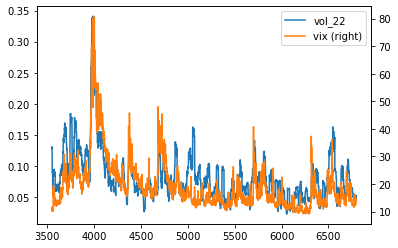

In [ ]:
df[df['TICKER']=='AAPL'][['vol_22', 'vix']].plot(secondary_y='vix')

In [ ]:
df[df['TICKER']=='AAPL'][['vol_22', 'vix']].corr()

,vol_22,vix
vol_22,1.000000,0.732804
vix,0.732804,1.000000


In [ ]:
#df.to_hdf('./data_AAPL/StockPriceAll.h5', key='StockPriceAll')

<AxesSubplot:>

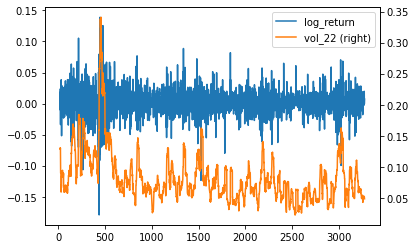

In [ ]:
df[df['TICKER'] == 'MSFT'][['log_return', 'vol_22']].plot(secondary_y='vol_22')

In [ ]:
df 

,date,TICKER,Price,Spread,ASK,BID,Price_adj_backward,log_return,vol_22,vix
22,20070205,MSFT,29.595000,0.01000,29.60000,29.59000,2.577866,-0.009558,0.130278,10.55
23,20070206,MSFT,29.510000,0.00000,29.51000,29.51000,2.584315,0.002502,0.128306,10.65
24,20070207,MSFT,29.375000,0.01000,29.38000,29.37000,2.645738,0.023768,0.130328,10.32
25,20070208,MSFT,29.260000,0.00000,29.26000,29.26000,2.646658,0.000348,0.130261,10.44
26,20070209,MSFT,28.940000,0.00000,28.94000,28.94000,2.557290,-0.033766,0.102293,11.10
...,...,...,...,...,...,...,...,...,...,...
45567,20191224,NFLX,333.240005,0.07999,333.28000,333.20001,70.234581,0.000951,0.050446,12.67
45568,20191226,NFLX,332.580000,0.10000,332.63000,332.53000,71.628067,0.019840,0.052653,12.65
45569,20191227,NFLX,329.084995,0.01001,329.09000,329.07999,71.600876,-0.000380,0.051107,13.43
45570,20191230,NFLX,323.304995,0.01001,323.31000,323.29999,72.025833,0.005935,0.049637,14.82


## All stocks

In [ ]:
t = pd.read_hdf('./data_AAPL/AAPL_Option_C_A.h5') 

In [ ]:
t.head()

,date,symbol_flag,cp_flag,strike_price,volume,open_interest,impl_volatility,delta,gamma,vega,...,moneyness,log_forward_moneyness,price,maturity,normalized_T,trade_diff,month,dS,dV,day_CSS
724431,2010-01-22,0,C,130000,107,2396,0.455159,0.877155,0.002262,40.15543,...,1.520577,0.424485,75.150,365,1.000000,0,1,26.659922,21.499937,NaN
724825,2010-01-25,0,C,130000,50,2372,0.445294,0.892427,0.002058,37.36773,...,1.561115,0.450981,79.400,362,0.991781,0,1,14.486684,11.702678,NaN
725219,2010-01-26,0,C,130000,5,2364,0.440747,0.899881,0.001949,35.93928,...,1.583731,0.464959,81.775,361,0.989041,0,1,9.884159,8.378464,NaN
725613,2010-01-27,0,C,130000,15,2364,0.439931,0.904166,0.001876,35.07963,...,1.599385,0.474569,83.500,360,0.986301,0,1,-41.482325,-35.470373,NaN
726007,2010-01-28,0,C,130000,24,2365,0.449506,0.883573,0.002207,38.62778,...,1.533038,0.432141,76.125,359,0.983562,0,1,-36.578942,-31.485989,NaN


In [ ]:
df = pd.read_hdf('./data_All/All_Option_C_A_output.h5') 

In [ ]:
df.columns[25:]

Index(['All_MVdelta_asset__traded_True_bucket_False',
       'All_MVdelta_rolling_traded_True_bucket_False',
       'All_DNN_asset__traded_True_bucket_False_feature_set_2_hidden_size_128_num_layers_3_sentiment_False',
       'All_DNN_universal_finetune_False_traded_True_bucket_False_feature_set_2_hidden_size_128_num_layers_3_sentiment_False',
       'All_DNN_universal_finetune_True_traded_True_bucket_False_feature_set_2_hidden_size_128_num_layers_3_sentiment_False',
       'All_MVdelta_universal__trade_True_bucket_False',
       'All_DNN_universal_finetune_True_transfer_True_bucket_False_feature_set_2_hidden_size_128_num_layers_3_sentiment_False',
       'All_DNN_rolling_traded_True_bucket_False_feature_set_2_hidden_size_128_num_layers_3_sentiment_False',
       'All_DNN_rolling_traded_True_bucket_False_feature_set_2_hidden_size_128_num_layers_3_sentiment_False_finetune_False'],
      dtype='object')

In [ ]:
gain_all = cal_method_bucket_gain(df, N=25)

In [ ]:
name1 = 'All_MVdelta_rolling_traded_True_bucket_False'
gain_all[name1]

delta_bucket,1,2,3,4,5,6,7,8,9,overall
ticker,,,,,,,,,,
AAPL,0.129980,0.144667,0.143981,0.142676,0.110044,0.083212,0.057108,0.025747,-0.000185,0.073718
AMD,-0.003738,-0.006568,-0.024896,-0.019896,-0.049399,-0.050531,-0.042702,-0.015140,-0.008696,-0.024559
AMZN,0.098134,0.135664,0.148586,0.125397,0.077892,0.031390,0.015539,0.004120,-0.011549,0.051888
BA,0.025350,0.047989,0.029353,0.015333,0.000425,0.001524,-0.002291,-0.002571,-0.001356,0.007840
BAC,0.056680,0.031490,0.002681,-0.037435,-0.074911,-0.072949,-0.032325,-0.009504,0.002194,-0.018470
CCL,0.089569,0.102222,0.028804,-0.001271,0.017686,0.022237,0.036782,0.013381,-0.000461,0.020697
CSCO,0.080273,0.087411,0.020815,0.040337,-0.023153,-0.022467,-0.029681,-0.004289,0.002905,0.000607
DAL,0.007813,0.013804,0.007316,0.006086,-0.003540,0.008084,0.009383,0.003431,-0.000879,0.005348
DIS,-0.038053,-0.059874,-0.076266,-0.081293,-0.076473,-0.072330,-0.035302,-0.006841,0.006502,-0.039853


In [ ]:
name = 'All_MVdelta_universal__trade_True_bucket_False'
gain_all[name]

delta_bucket,1,2,3,4,5,6,7,8,9,overall
ticker,,,,,,,,,,
AAPL,0.139736,0.147638,0.143449,0.137312,0.098841,0.072524,0.053461,0.040272,0.014948,0.076428
AMD,-0.009816,-0.025281,-0.069569,-0.070529,-0.128704,-0.134229,-0.110185,-0.041945,-0.012715,-0.066002
AMZN,0.082488,0.112729,0.124591,0.108599,0.075058,0.041550,0.023070,0.005853,0.004016,0.051487
BA,0.055588,0.066416,0.025333,-0.005535,-0.027337,-0.015636,-0.007727,0.002884,0.003383,0.002805
BAC,0.083537,-0.052859,-0.211710,-0.334998,-0.536977,-0.493595,-0.274363,-0.128137,-0.041405,-0.205334
CCL,0.080116,0.098319,0.039511,0.004683,0.011797,0.009295,0.019316,0.001120,-0.013451,0.011778
CSCO,0.087304,0.091652,0.018957,0.033496,-0.033284,-0.040025,-0.041467,-0.004696,-0.000496,-0.003864
DAL,0.011731,0.019443,0.008601,0.002709,-0.014236,0.002092,0.005683,0.001025,-0.005146,0.002854
DIS,-0.036802,-0.079449,-0.117039,-0.166673,-0.190257,-0.185199,-0.165191,-0.098182,-0.031878,-0.111700


In [ ]:
name = 'All_DNN_universal_finetune_True_traded_True_bucket_False_feature_set_2_hidden_size_128_num_layers_3_sentiment_False'
gain_all[name]

delta_bucket,1,2,3,4,5,6,7,8,9,overall
ticker,,,,,,,,,,
AAPL,0.299135,0.192836,0.156136,0.155862,0.118511,0.064030,0.033355,0.030239,0.012692,0.085157
AMD,-0.095055,-0.096892,-0.098793,-0.015221,-0.072848,-0.071932,-0.114649,-0.085294,-0.069974,-0.075809
AMZN,0.135664,0.123090,0.109116,0.099072,0.071007,0.039662,0.017050,0.003116,-0.021576,0.044852
BA,0.013831,-0.000655,-0.011224,-0.003636,-0.006052,-0.001664,-0.012554,-0.033008,-0.096339,-0.024133
BAC,0.091053,0.041028,0.022507,-0.024635,-0.130118,-0.227805,-0.139459,-0.068739,-0.033899,-0.068875
CCL,0.118673,0.092374,-0.045537,-0.039475,-0.015308,-0.052429,-0.073871,-0.145190,-0.120499,-0.068816
CSCO,0.155755,0.078600,-0.006029,0.033384,-0.010687,-0.015285,-0.027376,-0.003648,0.000099,0.000452
DAL,0.011775,0.022296,-0.004857,-0.013407,-0.024637,-0.005659,-0.031937,-0.048832,-0.088703,-0.025163
DIS,-0.221053,-0.227495,-0.201747,-0.189738,-0.196540,-0.174076,-0.176457,-0.220487,-0.211634,-0.202330


In [ ]:
name = 'All_DNN_rolling_traded_True_bucket_False_feature_set_2_hidden_size_128_num_layers_3_sentiment_False'
gain_all[name]

delta_bucket,1,2,3,4,5,6,7,8,9,overall
ticker,,,,,,,,,,
AAPL,0.263987,0.177477,0.145356,0.124781,0.097949,0.066698,0.039357,-0.002351,-0.015035,0.066897
AMD,0.073065,0.040346,0.021426,0.042666,-0.016764,-0.020401,-0.046540,-0.036802,-0.031432,-0.006892
AMZN,0.183155,0.172547,0.143146,0.116365,0.075830,0.035025,0.006026,-0.026766,-0.071984,0.039428
BA,0.062003,0.041624,0.016753,0.014170,0.005673,0.009205,0.006247,0.001265,-0.012691,0.008991
BAC,0.075986,0.025970,0.003262,-0.009043,-0.042079,-0.051327,-0.034974,-0.019260,0.003320,-0.012814
CCL,0.069228,0.084246,0.029016,0.018905,0.045833,0.047005,0.042502,0.012927,0.006212,0.028697
CSCO,0.155140,0.098365,0.012128,0.061841,0.000139,-0.004896,-0.030385,0.001431,0.002549,0.006196
DAL,0.014998,0.025060,0.007088,-0.001062,-0.010484,0.001808,-0.005504,-0.006603,-0.002627,0.001858
DIS,-0.190794,-0.134818,-0.109849,-0.110397,-0.094194,-0.082403,-0.063531,-0.052699,-0.018948,-0.077454


In [ ]:
mask = []
for i in range(gain_diff.shape[0]):
    if gain_diff.index[i] in ['CCL','DIS', 'JPM', 'NFLX']:
        mask.append(False)
    else:
        mask.append(True)
print(mask)

[True, True, True, True, True, False, True, True, False, True, True, True, False, True, False, True, True, True, True, True]


In [ ]:
gain_diff = gain_all[name] - gain_all[name1] 
gain_diff

delta_bucket,1,2,3,4,5,6,7,8,9,overall
ticker,,,,,,,,,,
AAPL,0.134006,0.032810,0.001375,-0.017895,-0.012095,-0.016514,-0.017751,-0.028098,-0.014850,-0.006822
AMD,0.076803,0.046914,0.046322,0.062561,0.032635,0.030130,-0.003837,-0.021662,-0.022736,0.017667
AMZN,0.085021,0.036883,-0.005440,-0.009032,-0.002062,0.003635,-0.009512,-0.030886,-0.060435,-0.012460
BA,0.036653,-0.006365,-0.012600,-0.001163,0.005248,0.007681,0.008538,0.003836,-0.011335,0.001151
BAC,0.019306,-0.005520,0.000581,0.028392,0.032832,0.021621,-0.002649,-0.009756,0.001126,0.005656
CCL,-0.020341,-0.017976,0.000211,0.020176,0.028147,0.024768,0.005720,-0.000454,0.006672,0.008000
CSCO,0.074867,0.010954,-0.008687,0.021504,0.023292,0.017571,-0.000705,0.005720,-0.000356,0.005589
DAL,0.007185,0.011255,-0.000228,-0.007148,-0.006944,-0.006276,-0.014888,-0.010033,-0.001748,-0.003490
DIS,-0.152741,-0.074944,-0.033583,-0.029104,-0.017720,-0.010072,-0.028229,-0.045858,-0.025450,-0.037602


In [ ]:
gain_diff.mean(axis=0)

delta_bucket
1          0.028382
2         -0.000150
3         -0.011185
4         -0.007064
5         -0.005228
6          0.000040
7         -0.007971
8         -0.008791
9         -0.010388
overall   -0.005603
dtype: float64

In [ ]:
gain_diff[mask].mean(axis=0)

delta_bucket
1          0.061911
2          0.018971
3         -0.001838
4         -0.002849
5         -0.004063
6          0.000228
7         -0.006756
8         -0.006774
9         -0.011096
overall   -0.001507
dtype: float64

<AxesSubplot:xlabel='ticker'>

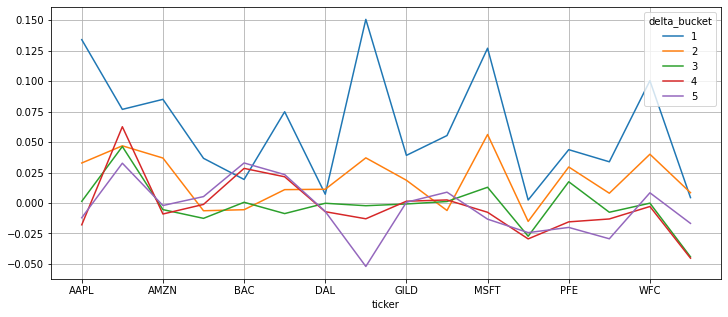

In [ ]:
gain_diff[mask].iloc[:,:5].plot(figsize=(12,5),grid=True)

In [ ]:
df 

,date,symbol_flag,cp_flag,strike_price,volume,open_interest,impl_volatility,delta,gamma,vega,...,dS,dV,All_MVdelta_asset__traded_True_bucket_False,All_MVdelta_rolling_traded_True_bucket_False,All_DNN_asset__traded_True_bucket_False_feature_set_2_hidden_size_128_num_layers_3_sentiment_False,All_DNN_universal_finetune_False_traded_True_bucket_False_feature_set_2_hidden_size_128_num_layers_3_sentiment_False,All_DNN_universal_finetune_True_traded_True_bucket_False_feature_set_2_hidden_size_128_num_layers_3_sentiment_False,All_MVdelta_universal__trade_True_bucket_False,All_DNN_universal_finetune_True_transfer_True_bucket_False_feature_set_2_hidden_size_128_num_layers_3_sentiment_False,All_DNN_rolling_traded_True_bucket_False_feature_set_2_hidden_size_128_num_layers_3_sentiment_False
39111263,2019-01-02,1,C,75000,6,2449,0.362831,0.942076,0.018131,2.041324,...,-49.717850,-40.689041,6.259734,5.861113,0.902059,0.910805,0.904527,6.259734,0.901947,0.895965
39111861,2019-01-03,1,C,75000,8,2443,0.438853,0.782625,0.041311,4.765375,...,33.691711,24.690586,-1.215663,-0.841668,0.759441,0.756206,0.763989,-1.215663,0.759735,0.736196
39111267,2019-01-02,1,C,80000,11,23504,0.384665,0.753618,0.046501,5.558012,...,-49.717850,-31.719632,4.982833,4.366968,0.728972,0.725015,0.733177,4.982833,0.728523,0.702238
39111866,2019-01-03,1,C,80000,128,23495,0.400442,0.521192,0.061321,6.461271,...,33.691711,16.814602,0.468893,0.626451,0.499392,0.490798,0.497269,0.468893,0.497814,0.475515
39111281,2019-01-02,1,C,85000,125,16728,0.354374,0.468588,0.063659,7.009321,...,-49.717850,-16.216216,5.341706,5.107768,0.446641,0.438786,0.446897,5.341706,0.443343,0.427205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39099079,2019-12-23,1,C,490000,3,0,0.331240,0.245255,0.002337,127.745500,...,0.435311,0.825590,0.599102,0.718186,0.254185,0.243749,0.246262,0.599102,0.252535,0.247509
39101347,2019-12-24,1,C,490000,0,2,0.333585,0.247473,0.002334,128.289300,...,-1.980570,0.000000,0.398722,0.457586,0.255343,0.245355,0.247801,0.398722,0.253757,0.248854
39103723,2019-12-26,1,C,490000,0,2,0.335350,0.247256,0.002328,127.772500,...,-10.508765,-2.255097,0.351868,0.197965,0.254211,0.244632,0.246959,0.351868,0.252793,0.247626
39106099,2019-12-27,1,C,490000,0,2,0.336812,0.239841,0.002307,124.229400,...,-17.563852,-6.229394,-1.931971,-2.248143,0.246749,0.237667,0.237839,-1.931971,0.245618,0.238877


### news process

In [ ]:
an = pd.read_hdf('./data_AAPL/AAPL_News.h5')

In [ ]:
an 

,RPNA_DATE_UTC,RPNA_TIME_UTC,ENTITY_TYPE,ENTITY_NAME,COUNTRY_CODE,RELEVANCE,ESS,AES,AEV,ENS,...,CSS,NIP,PEQ,BEE,BMQ,BAM,BCA,BER,ANL_CHG,MCQ
1281010,20100101,00:02:00.000,COMP,Apple Inc.,US,55,NaN,62,1562,NaN,...,50,44,50,50,50,50,50,50,50,50
1281011,20100101,00:02:00.000,COMP,Apple Inc.,US,93,NaN,62,1562,NaN,...,50,46,50,50,50,50,50,50,50,50
1281012,20100101,00:02:00.000,COMP,Apple Inc.,US,99,NaN,62,1562,NaN,...,50,36,50,50,50,50,50,50,50,50
1281013,20100101,00:04:00.000,COMP,Apple Inc.,US,99,NaN,62,1562,NaN,...,55,50,100,50,50,50,50,50,50,50
1281014,20100101,00:04:00.000,COMP,Apple Inc.,US,91,NaN,62,1562,NaN,...,50,35,50,50,50,50,50,50,50,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37577044,20191231,23:59:16.208,COMP,Apple Inc.,US,11,NaN,77,4827,NaN,...,50,34,50,50,50,50,50,50,50,50
37577045,20191231,23:59:16.218,COMP,Apple Inc.,US,1,NaN,77,4827,NaN,...,50,40,50,50,50,50,50,100,50,50
37577046,20191231,23:59:16.228,COMP,Apple Inc.,US,4,NaN,77,4827,NaN,...,52,62,50,50,100,50,50,50,50,50
37577047,20191231,23:59:16.258,COMP,Apple Inc.,US,2,NaN,77,4827,NaN,...,52,44,50,50,100,50,50,100,50,50


In [ ]:
def calculate_statistics(df):

    dfk = df.groupby('RPNA_DATE_UTC')['CSS'].apply(lambda x: (x.max(), x.quantile(0.9), x.quantile(0.1), x.min(),\
        x[x>50].count(), x[x<50].count(), x[x==50].count(), x.count()))
    dfk = pd.DataFrame(dfk.to_list(), index=dfk.index, columns=['max', '0.9', '0.1', 'min', 'pos_count', 'neg_count', 
                'neu_count', 'count'])

    dfk.index = pd.to_datetime(dfk.index, format='%Y%m%d')
    dfk['day_CSS'] = (dfk['pos_count'] - dfk['neg_count'])/(dfk['count']-dfk['neu_count'])
    return dfk


In [ ]:
sentiment = calculate_statistics(an)

<AxesSubplot:xlabel='RPNA_DATE_UTC'>

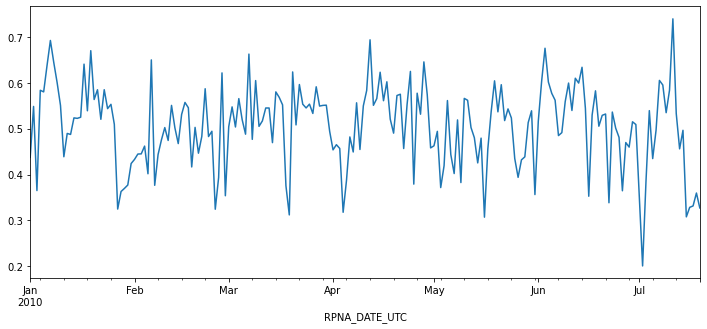

In [ ]:
sentiment['day_CSS'].iloc[:200].plot(figsize=(12,5))

In [ ]:
sentiment 

,max,0.9,0.1,min,pos_count,neg_count,neu_count,count,day_sentiment
RPNA_DATE_UTC,,,,,,,,,
2010-01-01,83,55.0,47.0,17,138,54,261,453,0.437500
2010-01-02,65,55.0,50.0,38,103,30,218,351,0.548872
2010-01-03,78,53.0,47.0,38,101,47,235,383,0.364865
2010-01-04,65,55.0,47.9,4,602,158,814,1574,0.584211
2010-01-05,65,55.0,50.0,17,901,239,1252,2392,0.580702
...,...,...,...,...,...,...,...,...,...
2019-12-27,83,55.0,50.0,17,792,182,1164,2138,0.626283
2019-12-28,65,55.0,50.0,24,275,81,586,942,0.544944
2019-12-29,65,55.0,50.0,38,253,57,523,833,0.632258


In [ ]:
t = pd.read_hdf('./data_All/All_News.h5')

In [ ]:
cps = t['COMPANY'].unique()
cps_entity = {}
for cp in cps:
    cps_entity[cp] = list(t[t['COMPANY']==cp]['ENTITY_NAME'].unique())


In [ ]:
print(len(cps_entity))
for key in cps_entity.keys():
    print(key, cps_entity[key])

101
US/AMZN ['Amazon.com Inc.']
US/CCL ['Carnival Corporation & plc']
GR/LODIS ['SingularLogic S.A.']
US/CSCO ['Cisco Systems Inc.']
AU/SEG ['Segue Resources Ltd.']
DE/INCO ['Intel Corp.']
DE/04335 ['Intel Corp.']
US/GE ['General Electric Co.']
US/MSFT ['Microsoft Corp.']
US/PFE ['Pfizer Inc.', 'Pacific Energy Resources Ltd.']
CA/FEY.P.V ['Golden Fame Resources Corp.']
CA/GFA.V ['Golden Fame Resources Corp.']
FR/SPR ['Sperian Protection S.A.']
BE/FLUX ['Fluxys S.A.', 'Fluxys Belgium S.A.']
CA/RD.V ['Rocher Deboule Minerals Corp.']
CA/AMY.V ['Rocher Deboule Minerals Corp.']
IT/GE ['Gefran S.p.A.']
IT/DAL ['Datalogic S.p.A.']
AU/CCL ['Coca-Cola Amatil Ltd.']
US/BA ['Boeing Co.', 'The Boeing Co.']
US/DAL ['Delta Air Lines Inc.']
US/JPM ['JPMorgan Chase & Co.']
CA/PFE ['Pacific Energy Resources Ltd.']
DE/BES ['Blavod Wines and Spirits Plc']
US/AMD ['Advanced Micro Devices Inc.']
MX/UAUA. ['United Continental Holdings Inc.']
MX/UAL ['United Continental Holdings Inc.']
DE/UAL ['United Contin

In [ ]:
ttk = tt.groupby('RPNA_DATE_UTC')['CSS'].apply(lambda x: (x.max(), x.quantile(0.9), x.quantile(0.1), x.min(),\
    x[x>50].count(), x[x<50].count(), x[x==50].count(), x.count()))
ttk = pd.DataFrame( ttk.to_list(), index=ttk.index, columns=['max', '0.9', '0.1', 'min', 'pos_count', 'neg_count', 
                'neu_count', 'count'])
#ttk = (ttk - 50)/50
ttk.index = pd.to_datetime(ttk.index, format='%Y%m%d')
for name in ['pos_count', 'neg_count', 'neu_count']:
    ttk[name] = ttk[name]/ ttk['count']

In [ ]:
ttk['day_sentiment'] = (ttk['pos_count'] - ttk['neg_count'])/(1-ttk['neu_count'])
ttk[['pos_s', 'neg_s', 'neu_s', 's']] = pd.DataFrame(tt.groupby('RPNA_DATE_UTC')['CSS'].apply(lambda x: (x[x>50].sum(),\
     x[x<50].sum(), x[x==50].sum(), x.sum())).to_list(), index=ttk.index)
for name in ['pos_s', 'neg_s', 'neu_s']:
    ttk[name] = ttk[name]/ ttk['s'] 
ttk['day_sentiment2'] = (ttk['pos_s'] - ttk['neg_s'])/(1-ttk['neu_s'])

In [ ]:
ttk 

,max,0.9,0.1,min,pos_count,neg_count,neu_count,count,day_sentiment,sum,pos_s,neg_s,neu_s,s,day_sentiment2
RPNA_DATE_UTC,,,,,,,,,,,,,,,
2010-01-01,83,55.0,47.0,38,0.400000,0.118182,0.481818,110,0.543860,NaN,0.424221,0.103829,0.471950,5615,0.606745
2010-01-02,55,55.0,50.0,47,0.428571,0.047619,0.523810,42,0.800000,NaN,0.445682,0.043640,0.510678,2154,0.821632
2010-01-03,65,52.0,46.0,38,0.187500,0.250000,0.562500,64,-0.142857,NaN,0.202839,0.229338,0.567823,3170,-0.061314
2010-01-04,78,55.0,47.0,38,0.447130,0.138973,0.413897,331,0.525773,NaN,0.469809,0.123493,0.406697,16843,0.583709
2010-01-05,56,55.0,50.0,38,0.328488,0.093023,0.578488,344,0.558621,NaN,0.344536,0.083822,0.571642,17406,0.608637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,83,55.0,47.0,31,0.525813,0.116635,0.357553,1569,0.636905,NaN,0.552140,0.101166,0.346694,80907,0.690296
2019-12-28,65,55.0,50.0,24,0.537500,0.043750,0.418750,320,0.849462,NaN,0.558152,0.037258,0.404589,16560,0.874848
2019-12-29,65,55.0,50.0,38,0.456000,0.060000,0.484000,250,0.767442,NaN,0.476450,0.051778,0.471772,12824,0.803956


In [ ]:
ttk[['day_sentiment','day_sentiment2']].corr()

,day_sentiment,day_sentiment2
day_sentiment,1.000000,0.996183
day_sentiment2,0.996183,1.000000


<AxesSubplot:xlabel='RPNA_DATE_UTC'>

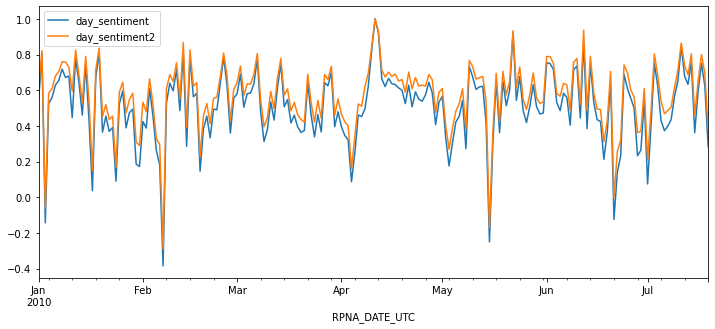

In [ ]:
ttk[['day_sentiment','day_sentiment2']].iloc[:200].plot(figsize=(12,5))

In [ ]:
tt.shape 

(2157500, 25)

In [ ]:
tt.head()

,RPNA_DATE_UTC,RPNA_TIME_UTC,ENTITY_TYPE,ENTITY_NAME,COUNTRY_CODE,RELEVANCE,ESS,AES,AEV,ENS,...,CSS,NIP,PEQ,BEE,BMQ,BAM,BCA,BER,ANL_CHG,MCQ
0,20100101,00:02:00.000,COMP,Amazon.com Inc.,US,89,NaN,81,455,NaN,...,50,41,50,50,50,50,50,50,50,50
1,20100101,00:16:00.000,COMP,Amazon.com Inc.,US,41,NaN,81,455,NaN,...,50,48,50,50,50,50,50,50,50,50
2,20100101,00:23:00.000,COMP,Amazon.com Inc.,US,74,NaN,81,455,NaN,...,47,41,50,50,0,50,50,50,50,50
3,20100101,00:30:00.000,COMP,Amazon.com Inc.,US,99,NaN,81,455,NaN,...,52,41,50,50,100,50,50,50,50,100
4,20100101,00:33:00.000,COMP,Amazon.com Inc.,US,1,NaN,81,455,NaN,...,55,44,50,50,50,50,100,50,50,50


### statistics analysis 
* data
    * news 
    * option
* daily volume and open interest 

In [ ]:
call = pd.read_hdf('./data_All/All_Option_C_A.h5') 

In [ ]:
def cal_liquidity(df, TYPE='C', name='option_liquidity.csv', save=False):
    cnt = df.groupby(['ticker', 'date'])[['volume', 'open_interest']].sum().unstack().T
    t = pd.concat({
        'volume':cnt.loc['volume'].mean(axis=0),
        'open_interest':cnt.loc['open_interest'].mean(axis=0)
    }, axis=1)#.to_csv('option_liquidity.csv')

    if save:
        t.to_csv(TYPE+'_'+name)
    return t 


In [ ]:
cal_liquidity(call, save=True)

,volume,open_interest
ticker,,
AAPL,112940.820931,1.446637e+06
AMD,24111.845328,4.475134e+05
AMZN,13352.050099,1.305249e+05
BA,7691.899006,1.176451e+05
BAC,124668.666402,2.920119e+06
CCL,1639.882306,3.711331e+04
CSCO,32237.811928,6.789206e+05
DAL,9254.118887,1.908372e+05
DIS,11786.482704,2.227473e+05


In [ ]:
put = pd.read_hdf('./data_All/All_Option_P_A.h5') 
cal_liquidity(put, TYPE='P', save=True)

,volume,open_interest
ticker,,
AAPL,60910.186630,8.285180e+05
AMD,14364.225447,3.719034e+05
AMZN,10802.772565,1.166113e+05
BA,5759.161034,1.043427e+05
BAC,64334.068787,1.922801e+06
CCL,1346.879125,2.945624e+04
CSCO,17892.502187,5.079733e+05
DAL,4257.552286,1.271304e+05
DIS,7006.339960,1.642718e+05


## SPX 

In [ ]:
k = pd.read_hdf('./data2_SPX/SPX_Option_C_E.h5')

In [ ]:
np.mean(k['dV']**2)

46.056972631016215

In [ ]:
df = k.copy()
print(df.shape)
df['bucket'] = df['delta'].apply(round_tenth)
num = df.groupby(['bucket', 'month'])['delta'].count().unstack()

(1442055, 23)


<AxesSubplot:xlabel='month'>

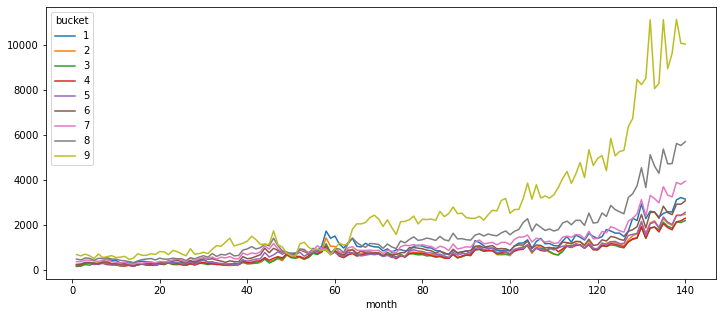

In [ ]:
num.T.plot(figsize=(12,5)) 

In [ ]:
df = k[k['volume']>0].copy()
print(df.shape)
df['bucket'] = df['delta'].apply(round_tenth)
num = df.groupby(['bucket', 'month'])['delta'].count().unstack()

(403498, 23)


<AxesSubplot:xlabel='month'>

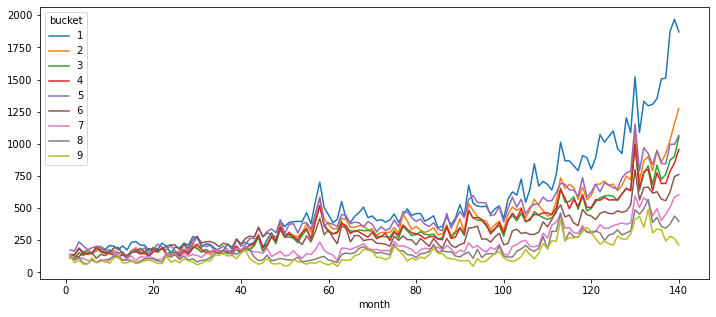

In [ ]:
num.T.plot(figsize=(12,5))

In [ ]:
df = pd.read_hdf('./data2_SPX/SPX_Option_C_E_output.h5') 
cal_gain_all_for_all_method(df, TYPE='C', N=22)

SPX_MVdelta_window_36_traded_False_bucket_False
0.23318058997318125
delta_bucket
1    0.211386
2    0.298989
3    0.306783
4    0.282347
5    0.255320
6    0.238145
7    0.246454
8    0.234216
9    0.139917
Name: hedge_error_sq, dtype: float64
SPX_MVdelta_window_36_traded_True_bucket_False
0.23171290540622957
delta_bucket
1    0.244054
2    0.322505
3    0.308672
4    0.272916
5    0.249771
6    0.244627
7    0.257527
8    0.230514
9    0.118563
Name: hedge_error_sq, dtype: float64
SPX_DNN_window_36_traded_True_bucket_False_feature_set_2_hidden_size_64_num_layers_3_sentiment_False
0.22372885504435647
delta_bucket
1    0.368194
2    0.335162
3    0.290501
4    0.278108
5    0.271817
6    0.264487
7    0.261989
8    0.226534
9    0.034199
Name: hedge_error_sq, dtype: float64
SPX_DNN_window_36_traded_False_bucket_False_feature_set_2_hidden_size_64_num_layers_3_sentiment_False
0.22597669756003447
delta_bucket
1    0.350446
2    0.344745
3    0.310160
4    0.285732
5    0.269341
6    0.2544

## AAPL

In [ ]:
df = pd.read_hdf('./data_AAPL/AAPL_Option_C_A_output.h5')
res = cal_gain_all_for_all_method(df, TYPE='C')


AAPL_DNN_window_36_traded_True_bucket_True_feature_set_2_hidden_size_64_num_layers_3_sentiment_False
0.10903009589106372
delta_bucket
1    0.326552
2    0.279433
3    0.239971
4    0.193888
5    0.138860
6    0.098568
7    0.056707
8    0.002816
9   -0.041725
Name: hedge_error_sq, dtype: float64
AAPL_DNN_window_36_traded_True_bucket_True_feature_set_1_hidden_size_64_num_layers_3_sentiment_False
0.0818887282742573
delta_bucket
1    0.248152
2    0.237284
3    0.207593
4    0.167682
5    0.105423
6    0.087463
7    0.045542
8   -0.024786
9   -0.063016
Name: hedge_error_sq, dtype: float64
AAPL_DNN_window_36_traded_True_bucket_False_feature_set_2_hidden_size_128_num_layers_4_sentiment_False
0.11011255378233509
delta_bucket
1    0.302457
2    0.263781
3    0.222666
4    0.180400
5    0.144667
6    0.110263
7    0.066673
8    0.016900
9   -0.034831
Name: hedge_error_sq, dtype: float64
AAPL_DNN_window_36_traded_True_bucket_False_feature_set_1_hidden_size_128_num_layers_4_sentiment_False
0.084

In [ ]:
def cal_delta_modified_gain(df, name, TYPE='C', mean=True):
    if 'MV' in name or 'xgb' in name: 
        gain, gain_bucket = cal_bucket_gain_all(df, name, True, TYPE=TYPE)  
    if 'DNN' in name:
        gain, gain_bucket = cal_bucket_gain_all(df, name, False, TYPE=TYPE)

    df[name+'M'] = df.apply(lambda x: x[name] if gain_bucket[x['delta_bucket']]>0 else x['delta'],axis=1)
    
    return cal_bucket_gain_all(df, name+'M', False, TYPE='C', mean=True)


In [ ]:
name = 'AAPL_DNN_window_36_traded_True_bucket_False_feature_set_2_hidden_size_64_num_layers_3_sentiment_False_vix_True'
cal_delta_modified_gain(df, name)

(0.10550838971496779,
 delta_bucket
 1    0.238537
 2    0.217036
 3    0.171757
 4    0.154363
 5    0.118167
 6    0.105425
 7    0.081247
 8    0.055420
 9    0.000000
 Name: hedge_error_sq, dtype: float64)

In [ ]:
res.to_csv('AAPL_Call_Gain.csv')

In [ ]:
df_P = pd.read_hdf('./data_AAPL/AAPL_Option_P_A_output.h5')
cal_gain_all_for_all_method(df_P, TYPE='P') 

AAPL_MVdelta_window_36_traded_True_bucket_False
0.0879438723598186
delta_bucket
1    0.006660
2    0.038193
3    0.071474
4    0.093203
5    0.111093
6    0.112210
7    0.119039
8    0.097493
9    0.072688
Name: hedge_error_sq, dtype: float64
AAPL_MVdelta_window_36_traded_True_bucket_True
0.08990525455421539
delta_bucket
1    0.003328
2    0.034806
3    0.069687
4    0.094243
5    0.110356
6    0.110637
7    0.119299
8    0.102596
9    0.083324
Name: hedge_error_sq, dtype: float64
AAPL_DNN_window_36_traded_True_bucket_False_feature_set_2_hidden_size_64_num_layers_3_sentiment_False
0.08387317377251413
delta_bucket
1   -0.062460
2    0.008868
3    0.059160
4    0.089966
5    0.110596
6    0.112447
7    0.111599
8    0.095300
9    0.096409
Name: hedge_error_sq, dtype: float64
AAPL_DNN_window_36_traded_True_bucket_True_feature_set_2_hidden_size_64_num_layers_3_sentiment_False
0.08423512929210164
delta_bucket
1   -0.029527
2    0.017436
3    0.057595
4    0.084851
5    0.098856
6    0.10884

In [ ]:
#res.to_csv('AAPL_Call_Gain.csv')

In [ ]:
t = df_P[df_P['volume']>0].copy()
print(t.shape)
t['bucket'] = t['delta'].apply(round_tenth_put)
num = t.groupby(['bucket', 'month'])['delta'].count().unstack()

(446912, 31)


<AxesSubplot:xlabel='month'>

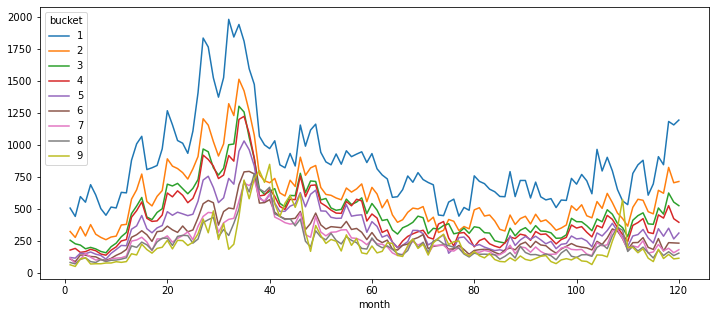

In [ ]:
num.T.plot(figsize=(12,5))

## for all stock options 

### clean middle files 

In [ ]:
import os 
def delete_middle_files(folder='./data_All/', cp_flag='C'):
    cnt = 0
    for f in os.listdir(folder):
        if 'Option_'+cp_flag in f and 'All' not in f:
            os.remove(folder + f)
            print(f + ' Removed')
            cnt += 1 
    return cnt 


In [ ]:
delete_middle_files('./data_All/', 'C')

UAL_Option_C_A.h5Removed
AMZN_Option_C_A.h5Removed
BAC_Option_C_A.h5Removed
BA_Option_C_A.h5Removed
CCL_Option_C_A.h5Removed
JPM_Option_C_A.h5Removed
DIS_Option_C_A.h5Removed
GE_Option_C_A.h5Removed
GILD_Option_C_A.h5Removed
MSFT_Option_C_A.h5Removed
NVDA_Option_C_A.h5Removed
PFE_Option_C_A.h5Removed
WMT_Option_C_A.h5Removed
WFC_Option_C_A.h5Removed
DAL_Option_C_A.h5Removed
AMD_Option_C_A.h5Removed
AAPL_Option_C_A.h5Removed
CSCO_Option_C_A.h5Removed
INTC_Option_C_A.h5Removed
NFLX_Option_C_A.h5Removed


20

In [ ]:
delete_middle_files('./data_All/', 'P') 

UAL_Option_P_A.h5 Removed
AMZN_Option_P_A.h5 Removed
BA_Option_P_A.h5 Removed
CCL_Option_P_A.h5 Removed
DIS_Option_P_A.h5 Removed
GE_Option_P_A.h5 Removed
NVDA_Option_P_A.h5 Removed
WMT_Option_P_A.h5 Removed
WFC_Option_P_A.h5 Removed
NFLX_Option_P_A.h5 Removed
DAL_Option_P_A.h5 Removed
AMD_Option_P_A.h5 Removed
AAPL_Option_P_A.h5 Removed
BAC_Option_P_A.h5 Removed
JPM_Option_P_A.h5 Removed
CSCO_Option_P_A.h5 Removed
GILD_Option_P_A.h5 Removed
INTC_Option_P_A.h5 Removed
MSFT_Option_P_A.h5 Removed
PFE_Option_P_A.h5 Removed


20

### Check different activation function

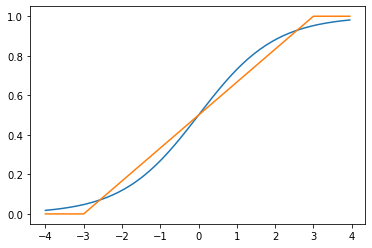

In [ ]:
import math 

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def hardsigmod(x):
    if x<=-3:
        return 0
    if x>=3:
        return 1
    
    return x/6+0.5

N = 20 
a = [i/N for i in range(-4*N,4*N)]
b = [sigmoid(x) for x in a]
c = [hardsigmod(x) for x in a]
plt.plot(a,b, a, c)